## Milestone Project 1: 🍔👁 Food Vision Big™

In the previous notebook (transfer learning part 3: scaling up) we built Food Vision mini: a transfer learning model which beat the original results of the Food101 paper with only 10% of the data.

But you might be wondering, what would happen if we used all the data?

Well, that's what we're going to find out in this notebook!

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

🔑 **Note: Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.
![foodVisionBig.png](Images/foodVisionBig.png)

Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:

* Prefetching
* Mixed precision training

But more on these later.

### What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model (see [transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb))
* Fine-tuning the feature extraction model (see [transfer learning part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb))
* Viewing training results on TensorBoard

## Check GPU

For this notebook, we're going to be doing something different.

We're going to be using mixed precision training.

Mixed precision training was introduced in `TensorFlow 2.4.0` (a very new feature at the time of writing).

### What does mixed precision training do?

**Mixed precision training** uses a combination of single precision (**float32**) and half-preicison (**float16**) data types to speed up model training (up 3x on modern GPUs).

We'll talk about this more later on but in the meantime you can read the [TensorFlow documentation on mixed precision](https://www.tensorflow.org/guide/mixed_precision) for more details.

For now, before we can move forward if we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible.

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+.

Google Colab offers P100, K80 and T4 GPUs, however, the P100 and K80 aren't compatible with mixed precision training.

Therefore before we proceed we need to make sure we have access to a Tesla T4 GPU in our Google Colab instance.

If you're not using Google Colab, you can find a list of various [Nvidia GPU compute capabilities](https://developer.nvidia.com/cuda-gpus#compute) on Nvidia's developer website.

🔑 Note: If you run the cell below and see a P100 or K80, try going to to Runtime -> Factory Reset Runtime (note: this will remove any saved variables and data from your Colab instance) and then retry to get a T4.

In [1]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

Init Plugin
2.5.0
Init Graph Optimizer
Init Kernel


## Get helper functions

We've created a series of helper functions throughout the previous notebooks in the course. Instead of rewriting them (tedious), we'll import the `helper_functions.py` file from the GitHub repo.

In [2]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In previous notebooks, we've downloaded our food images (from the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101/home)) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) (TFDS).

What is TensorFlow Datasets?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why not use TensorFlow Datasets?

The datasets are static (they don't change, like your real-world datasets would)
Might not be suited for your particular problem (but great for experimenting)
To begin using TensorFlow Datasets we can import it under the alias tfds.

In [6]:
#Get TensorFlow Datasets
!pip install tensorflow_datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after ("food101") is present.

In [7]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

2022-12-15 00:58:04.015795: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


True


Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).

To get access to the Food101 dataset from the TFDS, we can use the `tfds.load()` method.

In particular, we'll have to pass it a few parameters to let it know what we're after:

* `name` (str) : the target dataset (e.g. "`food101`")
* `split` (list, optional) : what splits of the dataset we're after (e.g. ["train", "validation"])
* the `split` parameter is quite tricky. See the documentation for more.
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to False
* `as_supervised` (bool) : True to download data samples in tuple format ((data, label)) or False for dictionary format
* `with_info` (bool) : True to download dataset metadata (labels, number of samples, etc)

🔑 **Note**: Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [8]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Metal device set to: Apple M1


2022-12-15 00:58:07.543504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-15 00:58:07.543734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Wonderful! After a few minutes of downloading, we've now got access to entire Food101 dataset (in tensor format) ready for modelling.

Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" variable (by using the `as_supervised=True` parameter in the `tfds.load()` method, note: this will only work for supervised datasets in TFDS).

We can access the class names of a particular dataset using the `dataset_info.features` attribute and accessing `names` attribute of the the "label" key.

In [9]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?
* To do, let's take one sample off the training data (using the `[.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it.

In [11]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure (data, label) or in our case (`image_tensor`, `label`).

In [12]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [13]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 64
  Class name (str form): miso_soup
        


2022-12-15 00:58:20.979435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-15 00:58:20.980851: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Because we set the shuffle_files=True parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example (512, 342, 3) and (512, 512, 3) (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [14]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 43,  89, 125],
        [ 52,  96, 131],
        [ 85, 128, 162],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       [[ 42,  88, 124],
        [ 53,  97, 132],
        [ 92, 135, 169],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       [[ 45,  89, 124],
        [ 52,  96, 131],
        [ 92, 135, 169],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       ...,

       [[ 91,  99,  86],
        [ 89,  97,  84],
        [ 88,  94,  82],
        ...,
        [ 37,  44,  50],
        [ 34,  41,  47],
        [ 31,  38,  44]],

       [[ 91,  99,  86],
        [ 90,  98,  85],
        [ 88,  96,  83],
        ...,
        [ 38,  43,  47],
        [ 35,  40,  44],
        [ 33,  38,  42]],

       [[ 93, 101,  88],
        [ 93, 101,  88],
        [ 89,  97,  84],
        ...,
        [ 37,  42,  4

In [15]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

## Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format, now let's really adhere to our motto.

"Visualize, visualize, visualize!"

Let's plot one of the image samples using `matplotlib.pyplot.imshow()` and set the title to target class name.

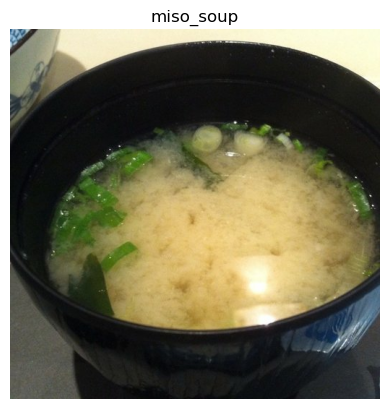

In [16]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

Delicious!

Okay, looks like the Food101 data we've got from TFDS is similar to the datasets we've been using in previous notebooks.

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method `tf.keras.utils.image_dataset_from_directory()` to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically, our data is currently:

In `uint8` data type
Comprised of all `differnet sized tensors` (different sized images)
Not scaled (the pixel values are between 0 & 255)
Whereas, models like data to be:

In `float32` data type
Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
Scaled (values between 0 & 1), also called normalized
To take care of these, we'll create a `preprocess_img()` function which:

1. Resizes an input image tensor to a specified size using `tf.image.resize()`
2. Converts an input image tensor's current datatype to `tf.float32` using `tf.cast()`

### 🔑 Note: Pretrained EfficientNetBX models in tf.keras.applications.efficientnet (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "preprocess_img()" function (like the one below) or within your model as a `tf.keras.layers.Rescaling layer`.

In [17]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Our `preprocess_img()` function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the `tuple structure (image, label)`.

Let's try our function out on a target image.

In [18]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 43  89 125]
  [ 52  96 131]
  [ 85 128 162]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 [[ 42  88 124]
  [ 53  97 132]
  [ 92 135 169]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 48.969387  93.68367  129.04082 ]
  [124.78572  164.07144  195.28572 ]
  [125.37245  158.94388  183.5153  ]
  ...
  [251.78574  254.78574  223.78574 ]
  [251.       254.       223.      ]
  [250.       253.       222.      ]]

 [[ 65.28572  108.688774 143.09183 ]
  [129.93878  169.09184  200.17348 ]
  [ 79.61224  115.04081  140.88266 ]
  ...
  [251.78574  254.78574  223.78574 ]
  [251.       254.       223.      ]
  [250.       253.       222.      ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our `preprocess_img()` function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to `(224, 224, 3)`.

How does it look?

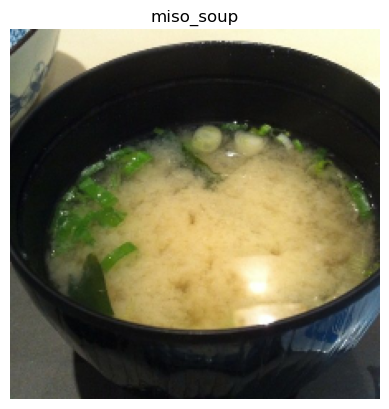

In [19]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

All this food visualization is making me hungry. How about we start preparing to model it?

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

### Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the `[tf.data`API](https://www.tensorflow.org/api_docs/python/tf/data).

### 📖 Resource: For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* `map()` - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
* `shuffle()` - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
* `batch()` - turns elements of a target dataset into batches (size defined by parameter batch_size)
* `prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* `Extra`: cache() - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)
Things to note:

* Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
* `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
* For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it `tonum_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
* Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
This is like saying,

"Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![prefetching](Images/prefetching.png)

What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). Source:* Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*

In [20]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

Excellent! Looks like our data is now in tutples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`, just what our model is after.

🔑 **Note: You can get away without calling the prefetch() method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to prefecth().

Onward.

Excellent! Looks like our data is now in tutples of (`image, label`) with datatypes of (`tf.float32, tf.int64`), just what our model is after.

🔑 **Note**: You can get away without calling the `prefetch()` method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to prefecth().

Onward.

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:

* **`tf.keras.callbacks.TensorBoard()`** - allows us to keep track of our model's training history so we can inspect it later (note: we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* **`tf.keras.callbacks.ModelCheckpoint()`** - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [22]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

## Setup mixed precision training

We touched on mixed precision training above.

However, we didn't quite explain it.

Normally, tensors in TensorFlow default to the `float32` datatype (unless otherwise specified).

In computer science, `float32` is also known as **single-precision floating-point** format. The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

**Mixed precision training** involves using a **mix of float16 and float32 tensors** to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means half-precision floating-point format. And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the TensorFlow mixed precision guide (I'd highly recommend at least checking out the summary).

![mixedPrecision.png](Images/mixedPrecision.png)

🔑 Note: If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Colab), mixed precision won't work (see: "[Supported Hardware](https://www.tensorflow.org/guide/mixed_precision#supported_hardware)" in the mixed precision guide for more).

📖 Resource: If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the [Wikipedia](https://en.wikipedia.org/wiki/Precision_(computer_science)) page (and accompanying resources).

Okay, enough talk, let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the `tensorflow.keras.mixed_precision` API has made it very easy for us to get started.

First, we'll import the API and then use the `set_global_policy()` method to set the dtype policy to "mixed_float16".

In [27]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Nice! As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the `mixed_precision.global_policy()` method.

In [28]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

Great, since the global dtype policy is now "mixed_float16" our model will automatically take advantage of float16 variables where possible and in turn speed up training.

## Build feature extraction model

* **Callbacks**: ready to roll.

* **Mixed precision**: turned on.

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (`EfficienetNetB0`).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

![featureExtractionModel1.png](Images/featureExtractionModel1.png)

To build the feature extraction model (covered in [Transfer Learning in TensorFlow Part 1: Feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb)), we'll:

* Use `EfficientNetB0` from `tf.keras.applications` pre-trained on `ImageNet` as our base model
    * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a Functional model
* Compile the Functional model using the Adam optimizer and sparse categorical crossentropy as the loss function (since our labels aren't one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks
🔑 **Note**: Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to the `float32 data type` which is **more numerically stable** than the `float16 datatype `(important for loss calculations). See the "Building the model" section in the TensorFlow mixed precision guide for more.

![withMixedPrecision.png](Images/withMixedPrecision.png)

In [23]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [24]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer dtype policies (are we using mixed precision?)

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's "`mixed_float16`").

We can check this by iterating through our model's layers and printing layer attributes such as dtype and dtype_policy.

In [25]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

* `layer.name (str)` : a layer's human-readable name, can be defined by the name parameter on construction
* `layer.trainable (bool)` : whether or not a layer is trainable (all of our layers are trainable except the * `efficientnetb0 layer` since we set it's trainable attribute to False
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in
🔑 **Note**: A layer can have a dtype of float32 and a dtype policy of "mixed_float16" because it stores its variables (weights & biases) in float32 (more numerically stable), however it computes in float16 (faster).

We can also check the same details for our model's base model.

In [26]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">
block2a_expand_activation False float32 <Policy "float32">


🔑 **Note**: The mixed precision API automatically causes layers which can benefit from using the "`mixed_float16`" dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

## Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

2022-12-15 01:05:32.036485: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-12-15 01:05:32.036512: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-12-15 01:05:32.037052: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20221215-010532
Epoch 1/3


2022-12-15 01:05:33.193919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


   1/2368 [..............................] - ETA: 4:23:42 - loss: 4.7202 - accuracy: 0.0312

2022-12-15 01:05:38.958095: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-12-15 01:05:38.958109: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


   2/2368 [..............................] - ETA: 16:20 - loss: 4.7245 - accuracy: 0.0312  

2022-12-15 01:05:39.301391: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-15 01:05:39.317220: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-12-15 01:05:39.331787: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20221215-010532/train/plugins/profile/2022_12_15_01_05_39
2022-12-15 01:05:39.335726: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to training_logs/efficientnetb0_101_classes_all_data_feature_extract/20221215-010532/train/plugins/profile/2022_12_15_01_05_39/SNIGDHAs-MacBook-Air-2.local.trace.json.gz
2022-12-15 01:05:39.343956: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20221215-010532/train/plugins/profile/2022_12_15_01_05_39
2022-12-1

2368/2368 [==============================] - ETA: 0s - loss: 1.8237 - accuracy: 0.5568

2022-12-15 01:15:02.759619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 599s 250ms/step - loss: 1.8237 - accuracy: 0.5568 - val_loss: 1.2221 - val_accuracy: 0.6769
Epoch 2/3
2368/2368 [==============================] - 637s 269ms/step - loss: 1.2921 - accuracy: 0.6667 - val_loss: 1.1381 - val_accuracy: 0.7007
Epoch 3/3
1818/2368 [======================>.......] - ETA: 2:29 - loss: 1.1455 - accuracy: 0.7026

Nice, looks like our feature extraction model is performing pretty well. How about we evaluate it on the whole test dataset?

In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

And since we used the `ModelCheckpoint callback`, we've got a saved version of our model in the model_checkpoints directory.

Let's load it in and make sure it performs just as well.

## Load and evaluate checkpoint weights

We can load in and evaluate our model's checkpoints by:

* Cloning our model using `tf.keras.models.clone_model()` to make a copy of our feature extraction model with reset weights.
* Calling the `load_weights()` method on our cloned model passing it the path to where our checkpointed weights are stored.
* Calling `evaluate()` on the cloned model with loaded weights.

A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [ ]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

In [ ]:
# Where are our checkpoints stored?
checkpoint_path

In [ ]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

In [ ]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

In [ ]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all(), "Loaded weights results are not close to orig

## Save the whole model to file

We can also save the whole model using the `save()` method.

Since our model is quite large, you might want to save it to Google Drive (if you're using Google Colab) so you can load it in for use later.

🔑 Note: Saving to Google Drive requires mounting Google Drive (go to Files -> Mount Drive).

In [ ]:
# ## Saving model to Google Drive (optional)

# # Create save path to drive 
# save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
# # os.makedirs(save_dir) # Make directory if it doesn't exist

# # Save model
# model.save(save_dir)

We can also save it directly to our Google Colab instance.

🔑 Note: Google Colab storage is ephemeral and your model will delete itself (along with any other saved files) when the Colab session expires.

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "08_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

That's what we want! Our loaded model performing as it should.

🔑 Note: We spent a fair bit of time making sure our model saved correctly because training on a lot of data can be time-consuming, so we want to make sure we don't have to continaully train from scratch.